# Clustering

Clustering is an important task in Machine Learning concerned with determining groups of observations based on their similarities. Usually "similarity" means proximity in the multidimensional space. We'll use the car dataset in our examples.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import hsv_to_rgb
from util.cars import draw_car

import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel('util/cars.xlsx')

df

,length,height,type,h,s,v,mileage
0,350,150,sedan,300,0.8,1.0,233587
1,500,180,van,25,0.7,0.7,87915
2,550,200,truck,140,0.1,0.6,59819
3,280,165,sedan,220,0.9,0.2,32682
4,620,230,van,220,1.0,0.5,355894
5,320,155,sedan,0,0.5,0.8,84232
6,730,285,truck,128,0.7,0.5,255416
7,490,170,van,85,0.4,0.4,55188
8,210,155,sedan,5,0.9,0.9,105879
9,460,160,van,90,0.2,0.2,58792


## Hierarchical Clustering

The code below builds a dendogram that clusters cars based on the variables 'length', 'height', 'h', 's', 'v'. See how the cars are grouped based on the size and color information.

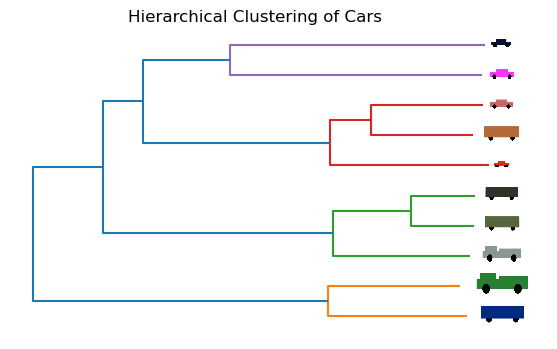

In [2]:

def cluster_and_visualize_cars(df, dummy_encode=False):
    # Prepare data for clustering

    X = df.copy()
    features = ['length', 'height', 'h', 's', 'v']

    if dummy_encode:
        # Dummy encode car type
        X = pd.get_dummies(df[features + ['type']], columns=['type'], drop_first=True)
    else:
        X = X[features]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform hierarchical clustering
    Z = linkage(X_scaled, method='ward')
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot dendrogram
    dendrogram(Z, ax=ax, orientation='left', leaf_rotation=0)

    # Get leaf positions
    leaf_positions = ax.get_yticks()

    # Get leaf labels
    leaf_labels = [int(label.get_text()) for label in ax.get_ymajorticklabels()]
    
    # Draw cars next to leaves
    for i, pos in zip(leaf_labels, leaf_positions):
        car = df.loc[i]
        car_image = draw_car(car['length'], car['height'], car['type'], car['h'], car['s'], car['v'])
        im = OffsetImage(car_image, zoom=0.0002*car['length'])  # Adjust zoom factor as needed
        ab = AnnotationBbox(im, (0, pos), xycoords='data', frameon=False)
        ax.add_artist(ab)
    
    # Adjust plot
    # ax.set_ylabel('Car Index')
    ax.set_title('Hierarchical Clustering of Cars')
    # remove all axes
    ax.axis('off')

    plt.tight_layout()
    plt.show()


# Call the function
cluster_and_visualize_cars(df)

We can also add the type of car to be considered in the clustering, but we need the type to be numerical. As we've seen before, we can use dummies to represent categorical values as numerical columns. Now we can see how the type of the car has more influence in the clusters.

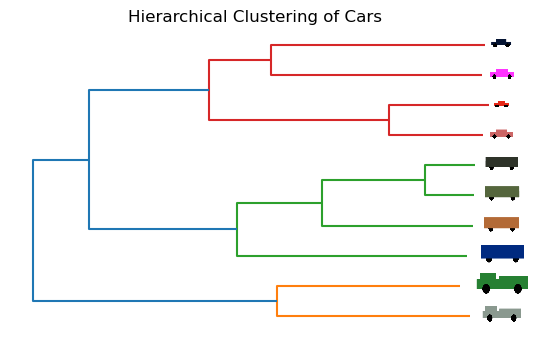

In [3]:
cluster_and_visualize_cars(df, dummy_encode=True)

## Clustering Text Documents

As long as our documents are represented with numerical vectors, we can apply clustering in the same way as for other types of data. The code below shows the clustering of a small corpus.

In [4]:
data = {
    'C': ['ship', 'boat', 'ocean', 'wood', 'tree'],
    'd1': [1, 0, 1, 1, 0],
    'd2': [0, 1, 1, 0, 0],
    'd3': [1, 0, 0, 0, 0],
    'd4': [0, 0, 0, 1, 1],
    'd5': [0, 0, 0, 1, 0],
    'd6': [0, 0, 0, 0, 1]
}

C = pd.DataFrame(data)

# Set 'C' as the index
C.set_index('C', inplace=True)

C

,d1,d2,d3,d4,d5,d6
C,,,,,,
ship,1,0,1,0,0,0
boat,0,1,0,0,0,0
ocean,1,1,0,0,0,0
wood,1,0,0,1,1,0
tree,0,0,0,1,0,1


{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [35.0, 35.0, 45.0, 45.0],
  [12.5, 12.5, 40.0, 40.0]],
 'dcoord': [[0.0, 1.0, 1.0, 0.0],
  [0.0, 1.7320508075688772, 1.7320508075688772, 1.0],
  [0.0, 1.7320508075688772, 1.7320508075688772, 0.0],
  [1.7320508075688772,
   2.23606797749979,
   2.23606797749979,
   1.7320508075688772]],
 'ivl': ['ship', 'boat', 'ocean', 'wood', 'tree'],
 'leaves': [0, 1, 2, 3, 4],
 'color_list': ['C1', 'C0', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C0', 'C0']}

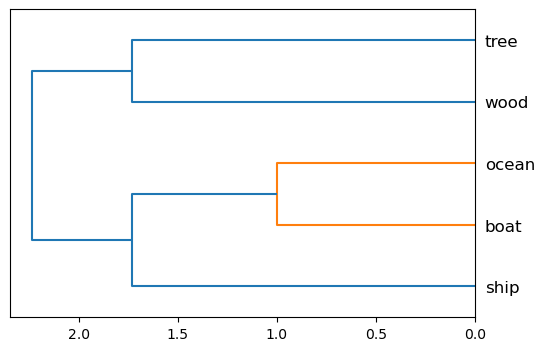

In [5]:
# make a dendogram for the clustering of C

Z = linkage(C, method='ward')

fig, ax = plt.subplots(figsize=(6, 4))

dendrogram(Z, ax=ax, orientation='left', labels=C.index)

In a dendogram, you can define a threshold value (in the x axis) to be used as the clustering criteria (i.e. the branches cut by the threshold line will become separate clusters). The code below defines the threshold as 2 and adds the defined clusters to the dataset.

In [6]:
# define a clusting threshold at 2, add clusters to dataframe C
from scipy.cluster.hierarchy import fcluster

C['cluster'] = fcluster(Z, 2, criterion='distance')

C

,d1,d2,d3,d4,d5,d6,cluster
C,,,,,,,
ship,1,0,1,0,0,0,1
boat,0,1,0,0,0,0,1
ocean,1,1,0,0,0,0,1
wood,1,0,0,1,1,0,2
tree,0,0,0,1,0,1,2


## K-means Clustering and Normalization

We'll now use the k-means clustering and a 2D visualization in the next examples. Below we have the cars represented as points in the height X length space, with the color representing the type of the car.

In [7]:
# shows a plotly scatterplot of cars by length and height

import plotly.express as px

fig = px.scatter(df, x='length', y='height', color='type')
fig.show()

We now use the k-means clustering to find 3 clusters in the same space. The colors represent the clusters found. The 3 clusters seem reasonable.

In [8]:
# clusters the cars using k-means and shows the clusters in a plotly scatterplot

from sklearn.cluster import KMeans

# Extract the features for clustering
features = ['length', 'height']
X = df[features]

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
kmeans.fit(X)

# Add cluster labels to the dataframe
df['cluster'] = kmeans.labels_

# Plot the clusters
fig = px.scatter(df, x='length', y='height', color='cluster')
fig.show()

We can do the same as before, but with the attributes 'length' and 'mileage'. See the chart below and try guess what 3 clusters we should expect.

In [9]:
fig = px.scatter(df, x='length', y='mileage')
fig.show() 

Now look at the clusters found below. Do they make sense? What has caused this behavior? (we have seen this problem before)

In [10]:
# Extract the features for clustering
features = ['length', 'mileage']
X = df[features]

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
kmeans.fit(X)

# Add cluster labels to the dataframe
df['cluster'] = kmeans.labels_

# Plot the clusters
fig = px.scatter(df, x='length', y='mileage', color='cluster')
fig.show()

## Normalizing the data

Since mileage has a wider range than length, we need to normalize the data before clustering. See how the clusters make more sense after normalizing the data.

In [11]:
# Extract the features for clustering
features = ['length', 'mileage']
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
kmeans.fit(X_scaled)

# Add cluster labels to the dataframe
df['cluster'] = kmeans.labels_

# Plot the clusters
fig = px.scatter(df, x='length', y='mileage', color='cluster')
fig.show()

Usually it makes no sense to cluster data based on only two variables because we can do it visually. A typical clustering task will involve several variables related the the properties that you think are relevant in the process of finding appropriate the groups. It is important to choose variables that are relevant to your problem/domain.

In the code below we cluster the data based on 5 variables and add the clusters identified to the original dataset.

In [12]:
# Extract the features for clustering
features = ['length', 'height', 'h', 's', 'v']
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
kmeans.fit(X_scaled)

# Add cluster labels to the dataframe
df['cluster'] = kmeans.labels_

df

,length,height,type,h,s,v,mileage,cluster
0,350,150,sedan,300,0.8,1.0,233587,0
1,500,180,van,25,0.7,0.7,87915,0
2,550,200,truck,140,0.1,0.6,59819,1
3,280,165,sedan,220,0.9,0.2,32682,1
4,620,230,van,220,1.0,0.5,355894,2
5,320,155,sedan,0,0.5,0.8,84232,0
6,730,285,truck,128,0.7,0.5,255416,2
7,490,170,van,85,0.4,0.4,55188,1
8,210,155,sedan,5,0.9,0.9,105879,0
9,460,160,van,90,0.2,0.2,58792,1
